In [61]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function

In [62]:
## I will create a dataset of one dimensional gaussian. Pass it through VAE and seee if the lateent space learns 
## the correct mu and sigma

def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)

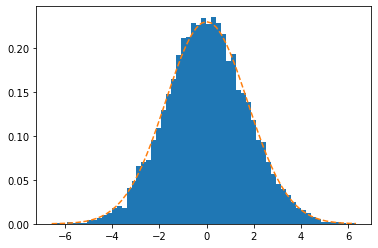

tensor(0.)
tensor(3.)


In [63]:
## Creating synthetic dataset
nb_samples=10000
mu  =torch.tensor(0.)   # . converts long to float
var =torch.tensor(3.0)
inp_data=sample(mu,var,nb_samples)
inp_data=inp_data.unsqueeze(0)
inp_data=torch.transpose(inp_data,0,1)
## for data visualization
inp_data_vis=inp_data.numpy()
n,bins,patches=plt.hist(inp_data_vis,'auto',density=1)
y=1/(np.sqrt(2*np.pi*var))*np.exp(-0.5*(bins-mu.numpy())**2/var)
plt.plot(bins,y,'--')
plt.show()
print(mu)
print(var)

In [64]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data    = inp_data*fun_A

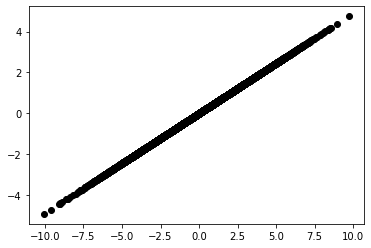

In [65]:
x_cord = data[:,0]
y_cord = data[:,1]
plt.plot(x_cord,y_cord, 'o', color='black')

In [66]:
## Hyperparameters
epochs     = 300
batch_size = 128
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [67]:
## Creating synthetic dataloader

train_loader = DataLoader(
    data[0:int(0.8*nb_samples),],   ## 80% of data used for training
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader = DataLoader(
    data[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [68]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)
latent_dim = 1
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        ## Encoder
        self.enc1 = nn.Linear(in_features = dim_exp,out_features = 64)
        self.enc2 = nn.Linear(in_features = 64     ,out_features = 32)
        self.enc3 = nn.Linear(in_features = 32     ,out_features = 2 )

        ## Decoder
        self.dec1 = nn.Linear(in_features = 1      ,out_features = dim_exp,bias=False)

    def reparameterize(self,mu,log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z   = mu+eps*std
        return z
    def forward(self,x):
        data    =  x
        ## encoding
        x       = F.relu(self.enc1(x))
        x       = self.enc2(x)
        ## reparametrization        
        mu      = x[:,0]
        log_var = x[:,1]
        z       = self.reparameterize(mu,log_var)
        z       = z.unsqueeze(0)
        z       = torch.transpose(z,0,1)

        ## decoding
        reconstruction  = self.dec1(z)
        
        ## finding loss
        beta=0.1
        mse_loss = nn.MSELoss(reduction='sum')
        MSE = mse_loss(reconstruction, data)
        KLD = 0.5 * (torch.sum(mu.pow(2) + log_var.exp()- log_var -1  ))
        loss= MSE+beta*KLD
        return mu,log_var,loss

In [69]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
def train(model,dataloader):
    model.train()
    running_loss = 0
    for i,data in enumerate(dataloader):
        data                      = data.to(device)
        mu,log_var,loss           = model(data)
        running_loss             += loss.item()
        loss.backward()                      
        optimizer.step()
    train_loss = running_loss/(len(dataloader.dataset))
    return train_loss
def test(model,dataloader):
    mean_pred = []
    var_pred  = []
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            data                      = data.to(device)
            mu,log_var,loss           = model(data)
            running_loss             += loss.item()
            mean_pred                += [torch.mean(mu)]
            var_pred                 += [torch.mean(torch.exp(log_var))]
    test_loss = running_loss/(len(dataloader.dataset))
    mean_pred = torch.stack(mean_pred,dim=0)
    var_pred  = torch.stack(var_pred,dim=0)
    mean_pred = torch.mean(mean_pred)
    var_pred  = torch.mean(var_pred)
    return test_loss,mean_pred,var_pred

In [70]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    #print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader)
    test_epoch_loss,mean_pred,var_pred = test(model,test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
print(f"Train Loss: {train_epoch_loss:.4f}")
print(f"Test Loss:  {test_epoch_loss:.4f}")
print(f"Mean Pred:  {mean_pred:.4f}")
print(f"Var  Pred:  {var_pred:.4f}")   

Train Loss: 0.6881
Test Loss:  0.7171
Mean Pred:  -0.0204
Var  Pred:  0.0109


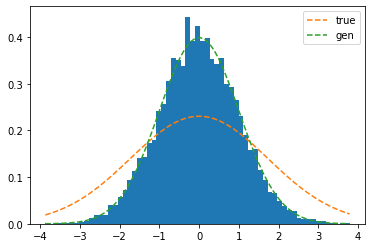

In [71]:
## Creating generated data
mean_pred  =torch.tensor(0.).cpu()   # . converts long to float
var_pred =torch.tensor(1.0).cpu()
gen_data  = sample(mean_pred,var_pred,nb_samples)
gen_data  = gen_data.unsqueeze(1)
## for data visualization
gen_data_vis=gen_data.cpu().numpy()

n,bins,patches=plt.hist(gen_data_vis,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var))*np.exp(-0.5*(bins-mu.numpy())**2/var)

y2=1/(np.sqrt(2*np.pi*var_pred.numpy()))*np.exp(-0.5*(bins-mean_pred.numpy())**2/var_pred.numpy())

plt.plot(bins,y1,'--',label='true')
plt.plot(bins,y2,'--',label='gen')
plt.legend()
plt.show()

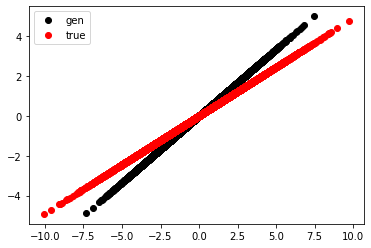

In [72]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
#fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
A=list(model.named_parameters())
A=A[-1]
m,dec_wgt=A
dec_wgt  = (torch.transpose(dec_wgt,0,1)).cpu()
data_sim= gen_data*dec_wgt

x1_cord = data_sim[:,0].cpu().detach().numpy()
y1_cord = data_sim[:,1].cpu().detach().numpy()
plt.plot(x1_cord,y1_cord, 'o', color='black',label='gen')
plt.plot(x_cord,y_cord, 'o', color='red',label='true')
plt.legend()
plt.show()

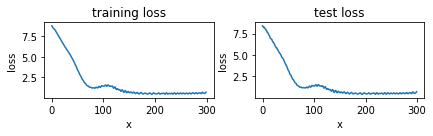

In [73]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

In [26]:
enc1 = nn.Linear(in_features = 1,out_features = 2)
print(data)
for parameter in enc1.parameters():
    print(parameter)
print(enc1(data))

tensor([[-0.1819],
        [ 0.5978],
        [-0.3839],
        [ 0.4683],
        [-0.3296]])
Parameter containing:
tensor([[-0.4732],
        [ 0.9657]], requires_grad=True)
Parameter containing:
tensor([ 0.7991, -0.2023], requires_grad=True)
tensor([[ 0.8851, -0.3780],
        [ 0.5161,  0.3751],
        [ 0.9807, -0.5730],
        [ 0.5774,  0.2500],
        [ 0.9550, -0.5206]], grad_fn=<AddmmBackward>)


In [173]:
enc1 = nn.Linear(in_features = 1,out_features = 2)
F.relu(enc1(data))

tensor([[0.0000, 0.0207],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.2933, 0.2515],
        [0.0000, 0.1351],
        [0.0179, 0.1819]], grad_fn=<ReluBackward0>)

In [424]:
A=list(model.named_parameters())[-1]
B=A[1].data.cpu()/fun_A.numpy()

In [401]:
A=list(model.named_parameters())
A[-1]

('dec1.weight',
 Parameter containing:
 tensor([[0.4872],
         [0.5423]], device='cuda:0', requires_grad=True))